In [355]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from geopy.distance import great_circle

import folium

import gmaps
import gmaps.datasets

api_key = 'API...'

gmaps.configure(api_key=api_key)

import googlemaps
gm = googlemaps.Client(key=api_key)

In [28]:
# Data from: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236
df = pd.read_csv('data/1702_378765078_T_ONTIME.csv')

In [29]:
# Select only Delta flights only
df = df[df['CARRIER']=='B6']

In [30]:
# considering only Tuesday Feb 7, 2017
df = df[df['DAY_OF_MONTH']==7]

In [31]:
# drop unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [32]:
print('number of active airplanes:', len(df['TAIL_NUM'].unique()))
print('number of destinations:', len(df['DEST'].unique()))
print('number of flights in Feb 7, 2017:', len(df))

number of active airplanes: 200
number of destinations: 62
number of flights in Feb 7, 2017: 788


In [33]:
# dict of tail num to airplane type
# run once
'''tag_num_list = df['TAIL_NUM'].unique()
tag_dict = {}
for tag_ in tag_num_list:
    page = requests.get('http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt=' + tag_)
    soup = BeautifulSoup(page.text, 'html.parser')
    for line in soup.findAll('span', attrs={'id': 'content_Label7'}):
        type_ = line.text.strip()
    tag_dict[tag_] = type_
    if len(tag_dict) % 10 == 0:
        print(len(tag_dict))'''

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [34]:
import pickle

'''pickle.dump( tag_dict, open("data/tag_dict_jb.p", "wb"))'''

# load data
tag_dict = pickle.load( open( "data/tag_dict_jb.p", "rb" ) )

In [50]:
df['aircraft_type'] = df['TAIL_NUM'].map(tag_dict)

In [51]:
df.groupby(['aircraft_type']).count()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
aircraft_type,,,,,,,,,,,,,,,,,,
182T,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3
510,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
A320-232,410,410,410,410,410,410,410,410,410,410,410,410,410,4,410,410,410,410
A321-231,56,56,56,56,56,56,56,56,56,56,56,56,56,0,56,56,56,56
AT-802A,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
DA 42,3,3,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3,3
DOMINATOR,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
ERJ 190-100 IGW,290,290,290,290,290,290,290,290,290,290,290,290,290,3,290,290,290,290
FALCON 900 EX,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2


In [56]:
# remove list small aircraft that are probably are being used for training
# such as SR22, DA42, Cessna 182T, etc.

df = df[(df['aircraft_type']=='A320-232')|(df['aircraft_type']=='A321-231')|(df['aircraft_type']=='ERJ 190-100 IGW')]

In [57]:
aircraft_capacity ={
    'A320-232':150,
    'A321-231':162,
    'ERJ 190-100 IGW':100,
}

In [58]:
df['aircraft_capacity'] = df['aircraft_type'].map(aircraft_capacity)

In [259]:
### ASSUMPTION same size aircraft###
aircraft_passengers ={
    'A320-232':100,
    'A321-231':100,
    'ERJ 190-100 IGW':100,
}
df['aircraft_passengers'] = df['aircraft_type'].map(aircraft_passengers)

In [260]:
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,...,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,aircraft_type,aircraft_capacity,ORIGIN_m,aircraft_passengers
10,2017,2,7,2,2017-02-07,B6,N249JB,33,BTV,JFK,...,0.0,NaN,0.0,90.0,266.0,2,ERJ 190-100 IGW,100,BTV,100
37,2017,2,7,2,2017-02-07,B6,N249JB,34,JFK,BTV,...,0.0,NaN,0.0,81.0,266.0,2,ERJ 190-100 IGW,100,JFK,100
64,2017,2,7,2,2017-02-07,B6,N766JB,42,LGB,RNO,...,0.0,NaN,0.0,87.0,402.0,2,A320-232,150,LGB,100
92,2017,2,7,2,2017-02-07,B6,N766JB,43,RNO,LGB,...,0.0,NaN,0.0,81.0,402.0,2,A320-232,150,RNO,100
120,2017,2,7,2,2017-02-07,B6,N316JB,49,BOS,SAV,...,0.0,NaN,0.0,169.0,901.0,4,ERJ 190-100 IGW,100,BOS,100
146,2017,2,7,2,2017-02-07,B6,N316JB,50,SAV,BOS,...,0.0,NaN,0.0,138.0,901.0,4,ERJ 190-100 IGW,100,SAV,100
172,2017,2,7,2,2017-02-07,B6,N623JB,51,BOS,MCO,...,0.0,NaN,0.0,205.0,1121.0,5,A320-232,150,BOS,100
199,2017,2,7,2,2017-02-07,B6,N527JB,52,MCO,BOS,...,0.0,NaN,0.0,167.0,1121.0,5,A320-232,150,MCO,100
240,2017,2,7,2,2017-02-07,B6,N913JB,54,PBI,JFK,...,0.0,NaN,0.0,164.0,1028.0,5,A321-231,162,PBI,100
266,2017,2,7,2,2017-02-07,B6,N179JB,56,IAD,BOS,...,0.0,NaN,0.0,86.0,413.0,2,ERJ 190-100 IGW,100,IAD,100


In [261]:
df_tmp = df[['ORIGIN', 'aircraft_passengers']]

In [262]:
df_tmp['NUM_of_passengers'] = df_tmp.groupby(['ORIGIN'])['aircraft_passengers'].transform('sum')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [263]:
df_tmp = df_tmp.drop(columns=['aircraft_passengers'])
df_tmp = df_tmp.drop_duplicates(subset=['ORIGIN'])

In [264]:
df_tmp

,ORIGIN,NUM_of_passengers
10,BTV,400
37,JFK,9700
64,LGB,3500
92,RNO,100
120,BOS,12600
146,SAV,300
199,MCO,4900
240,PBI,2100
266,IAD,600
474,SLC,700


In [265]:
def get_location(address):
    """returns latitude and longitude of the input address"""
    geocode_result = gm.geocode(address)[0]
    lat = geocode_result['geometry']['location']['lat']
    lng = geocode_result['geometry']['location']['lng']
    return [lat, lng]

In [266]:
m = folium.Map(location=[40, -98], tiles="Mapbox Bright", zoom_start=4)

for i, origin_ in enumerate(df_tmp['ORIGIN']):
    loc_ = get_location(origin_ + ' airport')
    size_ = df_tmp[df_tmp['ORIGIN']==origin_]['NUM_of_passengers'].values[0]
    folium.Circle(
          location=loc_,
          popup=origin_ + ', ' + str(size_),
          radius=np.sqrt(size_)*2000,
          color=None,
          fill=True,
          fill_color='crimson',
          fill_opacity=0.5,
       ).add_to(m)

In [268]:
print('Number of JetBlue passengers per day by airport (domestic routes only)')
m

Number of JetBlue passengers per day by airport (domestic routes only)


In [77]:
assigned_hub = {
    'ALB':'JFK',
    'AUS':'MCO',
    'BDL':'BOS',
    'BNA':'JFK',
    'BOS':'',
    'BQN':'SJU',
    'BTV':'BOS',
    'BUF':'JFK',
    'BUR':'LGB',
    'BWI':'JFK',
    'CHS':'MCO',
    'CLE':'JFK',
    'CLT':'JFK',
    'DAB':'MCO',
    'DCA':'JFK',
    'DEN':'SFO',
    'DFW':'MCO',
    'DTW':'JFK',
    'EWR':'JFK',
    'FLL':'',
    'HOU':'MCO',
    'HPN':'JFK',
    'IAD':'JFK',
    'JAX':'MCO',
    'JFK':'',
    'LAS':'LGB',
    'LAX':'LGB',
    'LGA':'JFK',
    'LGB':'',
    'MCO':'',
    'MSY':'MCO',
    'OAK':'SFO',
    'ORD':'JFK',
    'ORH':'BOS',
    'PBI':'FLL',
    'PDX':'SFO',
    'PHL':'JFK',
    'PHX':'LGB',
    'PIT':'JFK',
    'PSE':'SJU',
    'PSP':'LGB',
    'PVD':'BOS',
    'PWM':'BOS',
    'RDU':'JFK',
    'RIC':'JFK',
    'RNO':'SFO',
    'ROC':'JFK',
    'RSW':'MCO',
    'SAN':'LGB',
    'SAV':'MCO',
    'SEA':'SFO',
    'SFO':'',
    'SJC':'SFO',
    'SJU':'',
    'SLC':'SFO',
    'SMF':'SFO',
    'SRQ':'MCO',
    'STT':'SJU',
    'STX':'SJU',
    'SWF':'JFK',
    'SYR':'JFK',
    'TPA':'MCO',
}

In [118]:
# Merge airports in the same city for simplicity (i.e. only one airport in metro area can exist)

df['ORIGIN_m'] = np.where(df['ORIGIN']=='LGA', 'JFK', df['ORIGIN'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='HPN', 'JFK', df['ORIGIN_m'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='EWR', 'JFK', df['ORIGIN_m'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='BUR', 'LGB', df['ORIGIN_m'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='LAX', 'LGB', df['ORIGIN_m'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='SJC', 'SFO', df['ORIGIN_m'])
df['ORIGIN_m'] = np.where(df['ORIGIN_m']=='OAK', 'SFO', df['ORIGIN_m'])

In [125]:
list_of_hubs = []
for loc_ in list_of_airports:
    if assigned_hub[loc_] == '':
        list_of_hubs.append(loc_)

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

In [120]:
list_of_airports = df['ORIGIN'].unique()
list_of_airports = np.delete(list_of_airports, [np.where(list_of_airports =='LGA'),
                                                np.where(list_of_airports =='HPN'),
                                                np.where(list_of_airports =='EWR'),
                                                np.where(list_of_airports =='BUR'),
                                                np.where(list_of_airports =='LAX'),
                                                np.where(list_of_airports =='SJC'),
                                                np.where(list_of_airports =='OAK')])

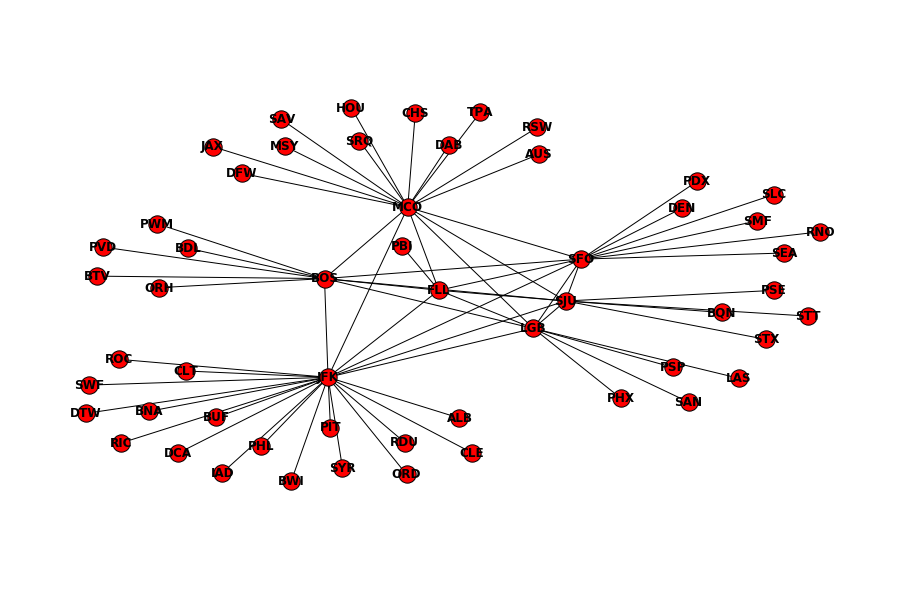

In [148]:
plt.figure(figsize=(12,8))
G = nx.Graph()

G.add_nodes_from(list_of_airports)

for i in range(len(list_of_hubs)):
    for j in range(i+1, len(list_of_hubs)):
        G.add_edge(list_of_hubs[i], list_of_hubs[j])
        
        
for loc_ in list_of_airports:
    if loc_ not in list_of_hubs:
        G.add_edge(loc_, assigned_hub[loc_])

nx.draw(G, with_labels=True, font_weight='bold')

In [269]:
routes = pd.DataFrame(columns=['ORIGIN', 'DEST', 'TIME', 'WEIGHT'])

In [270]:
for i in list_of_hubs:
    for j in list_of_hubs:
        if i != j:
            time_ = (great_circle(get_location(i + ' ' + 'airport'),get_location(j + ' ' + 'airport')).miles/500) +1.5
            weight_ = df_tmp[df_tmp['ORIGIN']==i]['NUM_of_passengers'].values[0] *\
                df_tmp[df_tmp['ORIGIN']==j]['NUM_of_passengers'].values[0]
            weight_ /= 10000
            routes = routes.append({'ORIGIN':i, 'DEST':j, 'TIME':time_, 'WEIGHT':weight_},
                            ignore_index=True)

In [271]:
for i in list_of_airports:
    if i not in list_of_hubs:
        j = assigned_hub[i]
        time_ = (great_circle(get_location(i + ' ' + 'airport'),get_location(j + ' ' + 'airport')).miles/500) +1.5
        weight_ = df_tmp[df_tmp['ORIGIN']==i]['NUM_of_passengers'].values[0] *\
                df_tmp[df_tmp['ORIGIN']==j]['NUM_of_passengers'].values[0]
        weight_ /= 10000
        routes = routes.append({'ORIGIN':i, 'DEST':j, 'TIME':time_, 'WEIGHT':weight_},
                            ignore_index=True)
        routes = routes.append({'ORIGIN':j, 'DEST':i, 'TIME':time_, 'WEIGHT':weight_},
                            ignore_index=True)
        

In [272]:
routes

,ORIGIN,DEST,TIME,WEIGHT
0,JFK,LGB,6.419242,3395.0
1,JFK,BOS,1.872615,12222.0
2,JFK,MCO,3.390651,4753.0
3,JFK,FLL,3.641534,6208.0
4,JFK,SJU,4.704138,2425.0
5,JFK,SFO,6.659940,1358.0
6,LGB,JFK,6.419242,3395.0
7,LGB,BOS,6.692206,4410.0
8,LGB,MCO,5.897747,1715.0
9,LGB,FLL,6.146568,2240.0


In [287]:
aircrafts = pd.DataFrame(columns=['AIRCRAFT', 'D0', 'TD0',
                                  'TA1', 'D1', 'TD1',
                                  'TA2', 'D2', 'TD2',
                                  'TA3', 'D3', 'TD3',
                                  'TA4', 'D4', 'TD4',
                                  'TA5', 'D5', 'TD5',
                                  'TA6', 'D6', 'TD6',
                                  'TA7', 'D7', 'TD7',
                                  'TA8', 'D8', 'TD8',
                                  ])

In [288]:
for i, orig_ in enumerate(df_tmp['ORIGIN']):
    aircrafts = aircrafts.append({'AIRCRAFT':i, 'D0':orig_, 'TD0':6.5},
                            ignore_index=True)
for j, orig_ in enumerate(list_of_hubs):
    for i in range(19):
        aircrafts = aircrafts.append({'AIRCRAFT':61+(j*19)+i, 'D0':orig_, 'TD0':6.5+(i*0.5)},
                            ignore_index=True)

In [352]:
def find_dest(origin):
    dest_options_ = routes[routes['ORIGIN']==origin]['DEST'].values
    dict_ = {k: list(v)[0] for k,v in df_rpc.groupby("ORIGIN")["NUM_of_passengers"]}
    p = np.vectorize(dict_.get)(routes[routes['ORIGIN']=='JFK']['DEST'].values)
    p = np.divide(p, sum(p))
    return np.random.choice(dest_options_, p=p)

In [345]:
def destination_assignment(time):
    for i in aircrafts['AIRCRAFT']:
        if aircrafts[aircrafts['AIRCRAFT']==i]['TD0'].values[0] > time:
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD1'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D1'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA1'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD0'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD1'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA1'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D1'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA1'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD0'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD1'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA1'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD2'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD1'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D2'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA2'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD1'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD2'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA2'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D2'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA2'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD1'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D1'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD2'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA2'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD3'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD2'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D3'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA3'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD2'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD3'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA3'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D3'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA3'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD2'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D2'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD3'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA3'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD4'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD3'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D4'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA4'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD3'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD4'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA4'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D4'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA4'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD3'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D3'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD4'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA4'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD5'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD4'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D5'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA5'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD4'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD5'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA5'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D5'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA5'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD4'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D4'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD5'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA5'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD6'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD5'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D6'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA6'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD5'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD6'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA6'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D6'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA6'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD5'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D5'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD6'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA6'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD7'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD6'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D7'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA7'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD6'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD7'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA7'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D7'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA7'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD6'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D6'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD7'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA7'].values[0]
            continue
        if np.isnan(aircrafts[aircrafts['AIRCRAFT']==i]['TD8'].values[0]):
            if aircrafts[aircrafts['AIRCRAFT']==i]['TD7'].values[0] > time:
                continue
            if aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0] not in list_of_hubs:
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D8'] = assigned_hub[aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0]]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA8'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD7'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D0'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D8'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD8'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA8'].values[0]
            else:
                dest_ = find_dest(aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0])
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'D8'] = dest_
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TA8'] = aircrafts[aircrafts['AIRCRAFT']==i]['TD7'].values[0] +\
                        routes[(routes['ORIGIN']==aircrafts[aircrafts['AIRCRAFT']==i]['D7'].values[0])&(routes['DEST']==aircrafts[aircrafts['AIRCRAFT']==i]['D8'].values[0])]['TIME'].values[0]
                aircrafts.loc[aircrafts['AIRCRAFT']==0, 'TD8'] = aircrafts[aircrafts['AIRCRAFT']==i]['TA8'].values[0]
            continue

In [286]:
# remaing passenger count by airport
df_rpc = df_tmp

In [326]:
df_rpc

,ORIGIN,NUM_of_passengers
10,BTV,400
37,JFK,9700
64,LGB,3500
92,RNO,100
120,BOS,12600
146,SAV,300
199,MCO,4900
240,PBI,2100
266,IAD,600
474,SLC,700


In [350]:
def filling_schedule():
    for time_ in np.arange(6.5,24.5,0.5):
        destination_assignment(time_)